In [1]:
import os
import pandas as pd
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
from lcmcmc.preprocessing import add_object_band_index, preprocess_SNANA, extract_subsample
from lcmcmc.utils import get_data_dir_path

# Load data

In [3]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'

In [4]:
df_head = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

# Load predictions

In [5]:
features_df = []

for file_num in range(45):
    print(file_num)
    
    trained_features = pd.read_pickle(os.path.join(data_dir, "train", f"train_{file_num}_data.pkl"))
    
    for index, row in trained_features.iterrows():

        current_obj_df = {}
        norm_fact = np.array([row['norm_factor']]*2000)

        features = np.concatenate((row['MCMC_samples_kn'], np.expand_dims(np.mean(row['data-likelihood']['data_value'], axis=2), 2)), axis=2).reshape((2000, 7))

        for band_num, band in enumerate(['g', 'r']):
            for coeff_num in range(3):
                current_obj_df[f"{band}coeff{coeff_num}"] = features[:, band_num*3+coeff_num]
        current_obj_df["likelihood"] = features[:, 6]

        current_obj_df["g_norm"] = norm_fact[:, 0]
        current_obj_df["r_norm"] = norm_fact[:, 1]

        current_obj_df=pd.DataFrame(current_obj_df)

        event_type = df_head[row['SNID']==df_head["SNID"]]["SNTYPE"].values[0]

        if event_type in [149, 150]:
            current_obj_df["type"]=1

        features_df.append(current_obj_df)

0


NameError: name 'data_dir' is not defined

In [ ]:
features_df = pd.concat(features_df, ignore_index=True)

In [6]:
predicted_scores = pd.read_pickle(os.path.join(get_data_dir_path(), "predicted_scores.pkl"))

In [7]:
predicted_scores

,SNID,KNe_prob,SNTYPE
0,4725641,0.533333,1
1,4725641,0.500000,1
2,4725641,0.533333,1
3,4725641,0.333333,1
4,4725641,0.533333,1
...,...,...,...
42575995,46307633,0.000000,0
42575996,46307633,0.000000,0
42575997,46307633,0.000000,0
42575998,46307633,0.000000,0


In [8]:
result = predicted_scores.groupby(['SNID'], as_index=False).agg(
                      {'KNe_prob':['mean','std'],'SNTYPE':'first'})

result.columns = ["SNID", "KNe_prob_mean", "KNe_prob_std", "SNTYPE"]

In [9]:
result

,SNID,KNe_prob_mean,KNe_prob_std,SNTYPE
0,1612,0.943333,0.049812,1
1,10871,0.002767,0.009198,0
2,10872,0.733393,0.149578,1
3,11422,0.257265,0.079316,0
4,13390,0.003800,0.010957,0
...,...,...,...,...
21283,137049400,0.029800,0.034469,0
21284,137051059,0.117333,0.056589,0
21285,137054088,0.012550,0.024699,0
21286,137071432,0.682933,0.101437,0


In [10]:
tp = (result["KNe_prob_mean"] > 0.5) & (result["SNTYPE"] ==1)
fp = (result["KNe_prob_mean"] > 0.5) & (result["SNTYPE"] !=1)
fn = (result["KNe_prob_mean"] < 0.5) & (result["SNTYPE"] ==1)
tn = (result["KNe_prob_mean"] < 0.5) & (result["SNTYPE"] !=1)

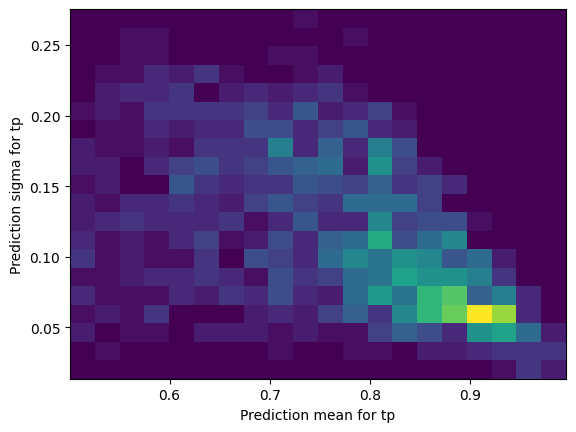

In [11]:
plt.hist2d(result[tp]["KNe_prob_mean"], result[tp]["KNe_prob_std"], bins=20);
plt.xlabel("Prediction mean for tp")
plt.ylabel("Prediction sigma for tp");

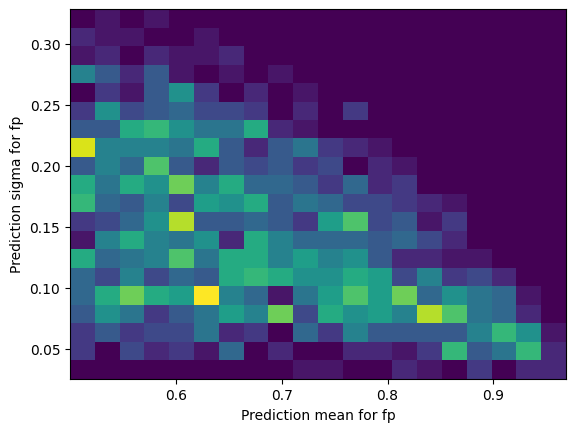

In [12]:
plt.hist2d(result[fp]["KNe_prob_mean"], result[fp]["KNe_prob_std"], bins=20);
plt.xlabel("Prediction mean for fp")
plt.ylabel("Prediction sigma for fp");

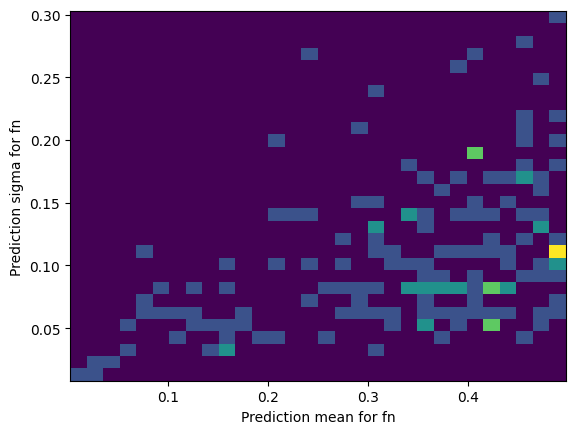

In [13]:
plt.hist2d(result[fn]["KNe_prob_mean"], result[fn]["KNe_prob_std"], bins=30);
plt.xlabel("Prediction mean for fn")
plt.ylabel("Prediction sigma for fn");

Text(0, 0.5, 'arbitrary units')

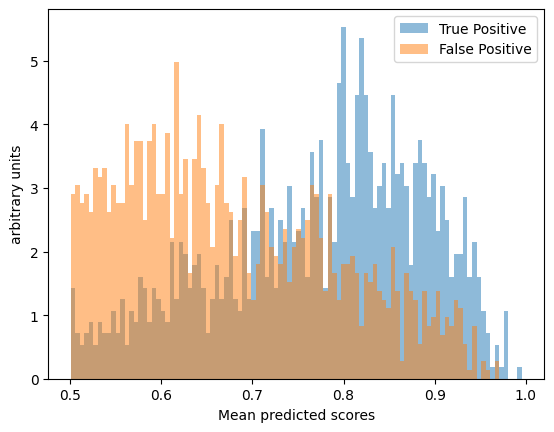

In [14]:
bins = plt.hist(result[tp]["KNe_prob_mean"], bins=100, alpha=.5, density=True, label="True Positive");
plt.hist(result[fp]["KNe_prob_mean"], bins=bins[1], alpha=.5, density=True, label="False Positive");
plt.legend()
plt.xlabel("Mean predicted scores")
plt.ylabel("arbitrary units")

# Scores violin plot

In [15]:

num_events_to_sample = 5

In [65]:
random_state=11
high_scores = result[result["KNe_prob_mean"]>.9]
high_scores = high_scores.sample(num_events_to_sample, random_state=random_state)
low_scores = result[(result["KNe_prob_mean"]>.5) & (result["KNe_prob_mean"]<.6)]
low_scores = low_scores.sample(num_events_to_sample, random_state=random_state)

In [66]:
high_scores

,SNID,KNe_prob_mean,KNe_prob_std,SNTYPE
4757,20038778,0.953047,0.037534,1
4770,20112716,0.908725,0.088660,1
1978,7382942,0.962919,0.055963,1
8760,46603317,0.942033,0.031804,0
12480,73581814,0.901079,0.078660,0


In [67]:
low_scores

,SNID,KNe_prob_mean,KNe_prob_std,SNTYPE
4677,19629214,0.509748,0.236365,0
3986,16403691,0.557033,0.085237,0
1951,7269722,0.509600,0.122963,1
12972,77215378,0.557315,0.222027,0
1476,5489765,0.555682,0.128288,1


In [68]:
import seaborn as sns

In [69]:
high_scores_plot_df = []
low_scores_plot_df =  []
for sample_num in range(num_events_to_sample):
    current_df_high = {}
    current_df_high["scores"] = predicted_scores["KNe_prob"][predicted_scores["SNID"]==high_scores["SNID"].iloc[sample_num]].values
    current_df_high = pd.DataFrame(current_df_high)
    current_df_high["gal_num"] = sample_num
    print(high_scores["SNTYPE"].iloc[sample_num])
    print("kn" if high_scores["SNTYPE"].iloc[sample_num] else "non-kn")
    current_df_high["type"] = "kn" if high_scores["SNTYPE"].iloc[sample_num] else "non-kn"
    
    high_scores_plot_df.append(current_df_high)
    
    current_df_low = {}

    current_df_low["scores"] = predicted_scores["KNe_prob"][predicted_scores["SNID"]==low_scores["SNID"].iloc[sample_num]].values
    current_df_low = pd.DataFrame(current_df_low)
    current_df_low["gal_num"] = sample_num + 5
    current_df_low["type"] = "kn" if low_scores["SNTYPE"].iloc[sample_num] else "non-kn"
    low_scores_plot_df.append(current_df_low)
    
high_scores_plot_df = pd.concat(high_scores_plot_df)
low_scores_plot_df = pd.concat(low_scores_plot_df)

1
kn
1
kn
1
kn
0
non-kn
0
non-kn


In [70]:
high_scores_plot_df

,scores,gal_num,type
0,0.954908,0,kn
1,0.954958,0,kn
2,0.989049,0,kn
3,0.986656,0,kn
4,0.923658,0,kn
...,...,...,...
1995,0.833147,4,non-kn
1996,1.000000,4,non-kn
1997,0.964580,4,non-kn
1998,0.733333,4,non-kn


<Axes: xlabel='gal_num', ylabel='scores'>

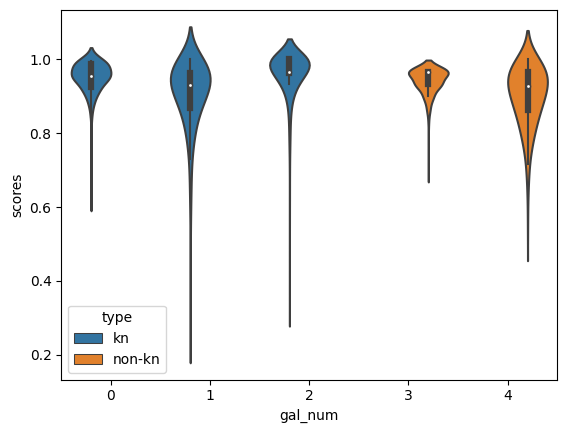

In [71]:
sns.violinplot(data=high_scores_plot_df, x="gal_num", y="scores", hue="type", bw=.5)

<Axes: xlabel='gal_num', ylabel='scores'>

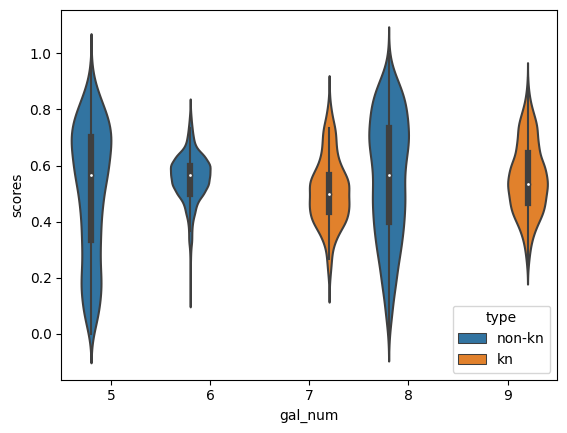

In [72]:
sns.violinplot(data=low_scores_plot_df, x="gal_num", y="scores", hue="type")

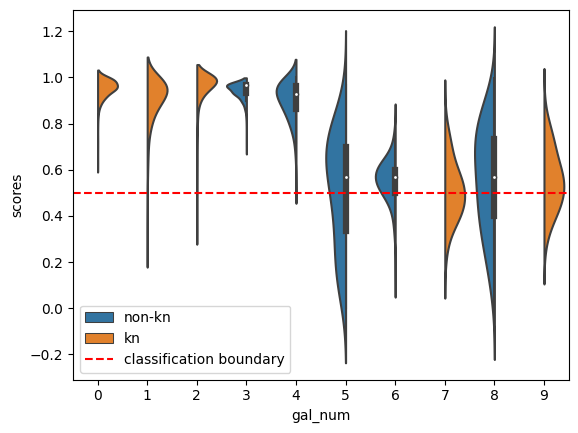

In [74]:
# This plot shows the distribution of scores for 10 events 5 with mean scores > .9 and 5 others with mean score>.5 and <.6
sns.violinplot(data=pd.concat((low_scores_plot_df, high_scores_plot_df)), x="gal_num", y="scores", hue="type", split=True, bw=.5)
plt.axhline(.5, ls="--", color ="r", label="classification boundary")
plt.legend(loc="lower left")